In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tilemapbase
import datetime
import pytz

In [5]:
source = 'combined'
sensor = 'pm25'
res_time = '1H'
filepath_root = '/scratch/ab9738/pollution_with_sensors/'

filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)
data.replace(0,np.nan,inplace=True)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/pollution_with_sensors/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [6]:
detected = np.array([27,27,14,12,23,32,32,32,32,32,32,32,32,26,23,2,14,32,32,31,31,31,29,9,27,7,5,0,21])

In [10]:
hidden = np.array([10,7,4,1,11,13,15,16,16,16,16,9,12,0,2,1,4,7,8,8,5,4,3,0,0,0,0,0,0])

In [39]:
time = [(2018,5)]
for i in range(1,29):
    curr = time[i-1]
    if(curr[1]!=12):
        nex = (curr[0],curr[1]+1)
    else:
        nex = (curr[0]+1,1)
    time.append(nex)

In [41]:
time = [str(i)+'-'+str(j) for (i,j) in time]

Text(0.5, 1.0, 'Longitudinal Trend of Hotspots')

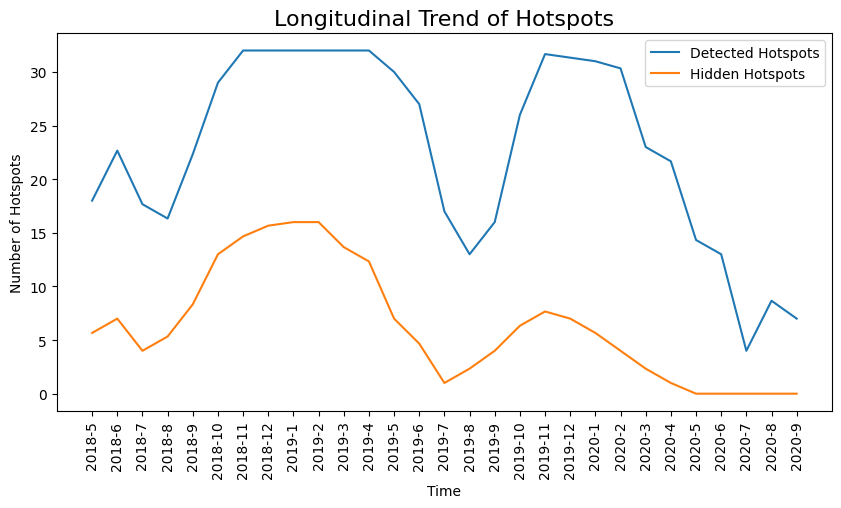

In [47]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(time, np.convolve(detected, np.ones(3)/3, mode='same'), label='Detected Hotspots')
ax.plot(time, np.convolve(hidden, np.ones(3)/3, mode='same'), label='Hidden Hotspots')
plt.legend()
plt.xticks(rotation=90)
ax.set_ylabel("Number of Hotspots")
ax.set_xlabel("Time")
plt.title("Longitudinal Trend of Hotspots",size=16)

spatial extension table

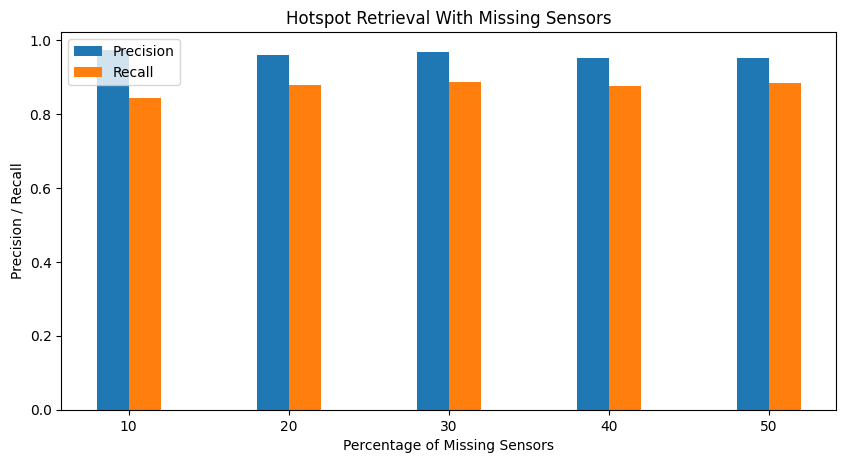

In [57]:
percent = np.array([10,20,30,40,50])
precision = [0.973, 0.961, 0.967, 0.953, 0.953]
recall = [0.843, 0.880, 0.888, 0.877, 0.885]
fig,ax =  plt.subplots(figsize=(10,5), dpi=100)
plt.bar(percent-1, precision, label='Precision', width=2)
plt.bar(percent+1, recall, label = 'Recall', width=2)
ax.set_xlabel("Percentage of Missing Sensors")
ax.set_ylabel("Precision / Recall")
plt.title("Hotspot Retrieval With Missing Sensors")
plt.legend()
plt.show()

random failure table

<function matplotlib.pyplot.show(close=None, block=None)>

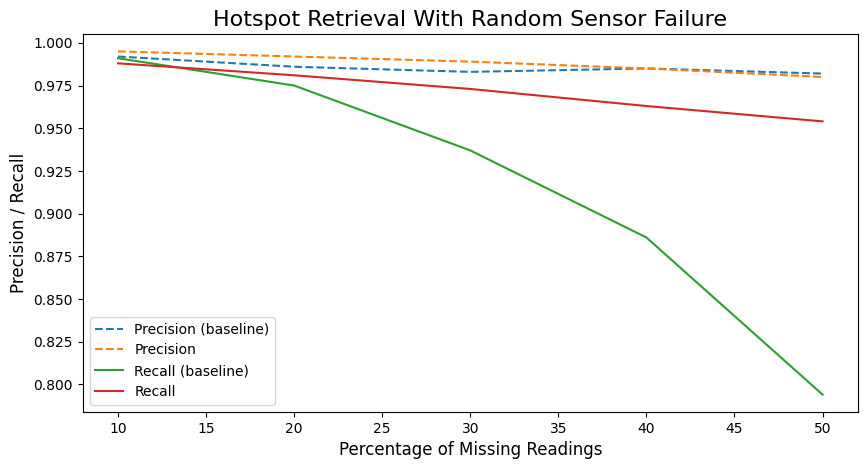

In [68]:
percent = np.array([10,20,30,40,50])
p_base = [0.992,0.986,0.983,0.985,0.982]
r_base = [0.991,0.975,0.937,0.886,0.794]
p = [0.995,0.992,0.989,0.985,0.980]
r = [0.988,0.981,0.973,0.963,0.954]
fig,ax =  plt.subplots(figsize=(10,5), dpi=100)
plt.plot(percent,p_base,label="Precision (baseline)",linestyle='--')
plt.plot(percent,p,label="Precision",linestyle='--')
plt.plot(percent,r_base,label="Recall (baseline)")
plt.plot(percent,r,label="Recall")
plt.legend()
plt.title("Hotspot Retrieval With Random Sensor Failure",size=16)
ax.set_xlabel("Percentage of Missing Readings",size=12)
ax.set_ylabel("Precision / Recall",size=12)
plt.show

performance table

<ErrorbarContainer object of 3 artists>

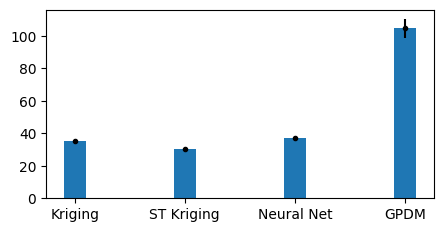

In [74]:
methods = ['Kriging', 'ST Kriging', 'Neural Net', 'GPDM']
mape = [35.06,30.24,37.31,104.52]
mape_err = [0.57, 0.31,0.78,6.00]
fig,ax =  plt.subplots(figsize=(5,2.5), dpi=100)
plt.bar(methods,mape,width=0.2)
plt.errorbar(methods,mape,mape_err,color='Black',fmt='.')